# Wasserstein GAN in Pytorch

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.
/home/flend/anaconda3/envs/pytorch/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import torch_utils; importlib.reload(torch_utils)
from torch_utils import *

The good news is that in the last month the GAN training problem has been solved! [This paper](https://arxiv.org/abs/1701.07875) shows a minor change to the loss function and constraining the weights allows a GAN to reliably learn following a consistent loss schedule.

First, we, set up batch size, image size, and size of noise vector:

In [3]:
bs,sz,nz = 256,64,100

Load dungeon maps from data/maps

In [4]:
import csvdataset; importlib.reload(csvdataset)
from csvdataset import CSVDataset

mapsLoader = CSVDataset("data/digger", "map", 20000)
dataloader = torch.utils.data.DataLoader(mapsLoader, bs, True, num_workers=4)

n = len(dataloader);
n

79

In [5]:
mapsLoader[0].shape

torch.Size([1, 64, 64])

Our activation function will be `tanh`, so we need to do some processing to view the generated images.

In [6]:
def show(img, fs=(6,6)):
    plt.figure(figsize = fs)
    plt.imshow(np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')

## Create model

The CNN definitions are a little big for a notebook, so we import them.

In [7]:
import dcgan; importlib.reload(dcgan)
from dcgan import DCGAN_D, DCGAN_G

Pytorch uses `module.apply()` for picking an initializer.

In [8]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)): 
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [10]:
netG = DCGAN_G(sz, nz, 1, 64, 1, 5).cuda()
netG.apply(weights_init);

In [11]:
netD = DCGAN_D(sz, 1, 64, 1, 5).cuda()
netD.apply(weights_init);

Just some shortcuts to create tensors and variables.

In [12]:
from torch import FloatTensor as FT
def Var(*params): return Variable(FT(*params).cuda())

In [13]:
def create_noise(b): 
    return Variable(FT(b, nz, 1, 1).cuda().normal_(0, 1))

In [14]:
# Input placeholder
input = Var(bs, 3, sz, nz)
# Fixed noise used just for visualizing images when done
fixed_noise = create_noise(bs)
# The numbers 0 and -1
one = torch.FloatTensor([1]).cuda()
mone = one * -1

An optimizer needs to be told what variables to optimize. A module automatically keeps track of its variables.

In [15]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

One forward step and one backward step for D

In [16]:
def step_D(v, init_grad):
    err = netD(v)
    err.backward(init_grad)
    return err

In [17]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

In [18]:
lossD = []
lossG = []
lossDreal = []
lossDfake = []

In [19]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in range(niter):
        epoch_filename = str.format('gen_epoch_{}.pt', epoch)
        if not (epoch - 1) % 100:
            torch.save(netG, epoch_filename)
        data_iter = iter(dataloader)
        i = 0
        while i < n:
            make_trainable(netD, True)
            d_iters = (100 if first and (gen_iterations < 25) or gen_iterations % 500 == 0 
                       else 5)

            j = 0
            while j < d_iters and i < n:
                j += 1; i += 1
                for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                real = Variable(next(data_iter).cuda())
                netD.zero_grad()
                errD_real = step_D(real, one)

                fake = netG(create_noise(real.size()[0]))
                input.data.resize_(real.size()).copy_(fake.data)
                errD_fake = step_D(input, mone)
                errD = errD_real - errD_fake
                optimizerD.step()
                #print('i[%d]' % i)

            make_trainable(netD, False)
            netG.zero_grad()
            errG = step_D(netG(create_noise(bs)), one)
            optimizerG.step()
            gen_iterations += 1
            
            print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f' % (
            epoch, niter, gen_iterations, n,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))
            lossD.append(errD.data[0])
            lossG.append(errG.data[0])
            lossDreal.append(errD_real.data[0])
            lossDfake.append(errD_fake.data[0])

    torch.save(netG, epoch_filename)

In [ ]:
%time train(2000, True)

[0/2000][1/79] Loss_D: -1.456145 Loss_G: 0.712840 Loss_D_real: -0.768448 Loss_D_fake 0.687696
[1/2000][2/79] Loss_D: -1.527896 Loss_G: 0.735281 Loss_D_real: -0.810444 Loss_D_fake 0.717452
[2/2000][3/79] Loss_D: -1.545955 Loss_G: 0.739038 Loss_D_real: -0.822834 Loss_D_fake 0.723121
[3/2000][4/79] Loss_D: -1.556812 Loss_G: 0.741134 Loss_D_real: -0.830669 Loss_D_fake 0.726144
[4/2000][5/79] Loss_D: -1.560863 Loss_G: 0.742411 Loss_D_real: -0.833355 Loss_D_fake 0.727508
[5/2000][6/79] Loss_D: -1.565607 Loss_G: 0.744108 Loss_D_real: -0.836346 Loss_D_fake 0.729261
[6/2000][7/79] Loss_D: -1.567721 Loss_G: 0.744603 Loss_D_real: -0.837752 Loss_D_fake 0.729969


In [26]:
torch.save(netG, "gen_1170.pt")

In [221]:
# dimension checking
#batch = next(iter(dataloader))
#batch


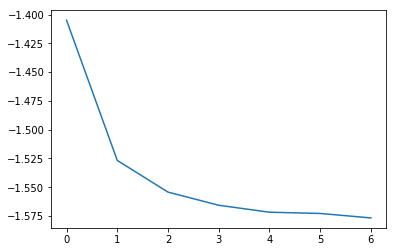

In [142]:
plt.plot(lossD)

## View

In [143]:
fake = netG(fixed_noise).data.cpu()

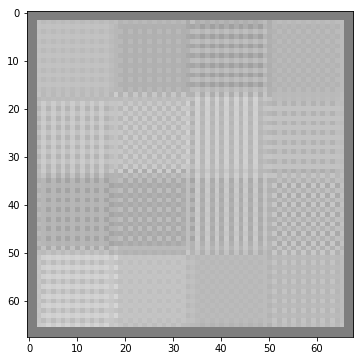

In [144]:
show(vutils.make_grid(fake[6:7,:,:,:]))

In [225]:
fake[44,0,:,:]


 0.0059  0.0013  0.0025  ...   0.0022  0.0039  0.0123
 0.0008  0.0016  0.0299  ...   0.0070  0.0176  0.0018
 0.0007  0.0034  0.0265  ...   0.0136  0.0339  0.0042
          ...             ⋱             ...          
 0.0008  0.0065  0.0428  ...   0.0164  0.0126  0.0014
 0.0008  0.0115  0.0322  ...   0.0173  0.0152  0.0017
 0.0075  0.0015  0.0029  ...   0.0016  0.0025  0.0074
[torch.FloatTensor of size 64x64]

In [139]:
fakeshow(vutils.make_grid(iter(dataloader).next()[0]))

NameError: name 'fakeshow' is not defined

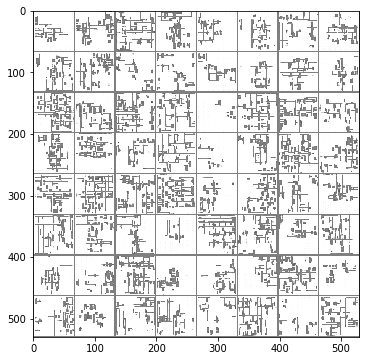

In [186]:
show(vutils.make_grid(fake))

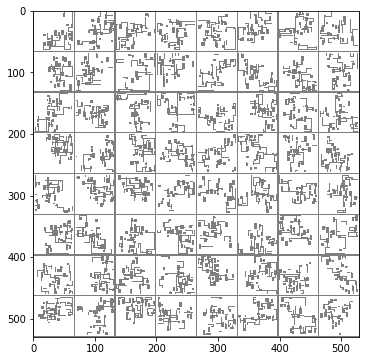

In [180]:
show(vutils.make_grid(iter(dataloader).next()))